In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:\
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
np.random.seed(42)

Machine Learning Project Checklist 

1. Look at the big picture and frame the problem
2. Get the data
3. Explore the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select and Train Model
6. Fine-tune your model


# 1. Frame the problem

The task is to find out who survived the disaster given a set of details about a passenger on the titanic. An output of 1, if they survived and 0, if they hadn't survived. This is a supervised problem and a classifcation task.

**Performance Measure** - data is not skewed so accuracy should be a reasonable performance measure.

# 2. Getting the Data

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv', index_col=0)
test_data = pd.read_csv('/kaggle/input/titanic/test.csv',index_col=0)

## Quick look at the Data Structure

In [4]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


A total of 11 attributes: `Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked`.

In [5]:
train_data.info() # quick description of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Very small amount of data will be implementing cross validation during validation of models.
Let's have a closer look at text attributes.

In [6]:
text_attributes = [col for col in train_data.columns if train_data[col].dtype=='object']
text_attributes

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Two categorical attributes which are `Embarked` and `Sex`. It seems that cabin is missing a lot values.

In [7]:
train_data["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
CA 2144     6
3101295     6
           ..
28424       1
PC 17599    1
347074      1
345767      1
113773      1
Name: Ticket, Length: 681, dtype: int64

There may seem to be a pattern there where some tickets are just numbers while others also include letters at the start. Now to have a look at the numerical attributes.

In [8]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only `Age` is missing some values.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

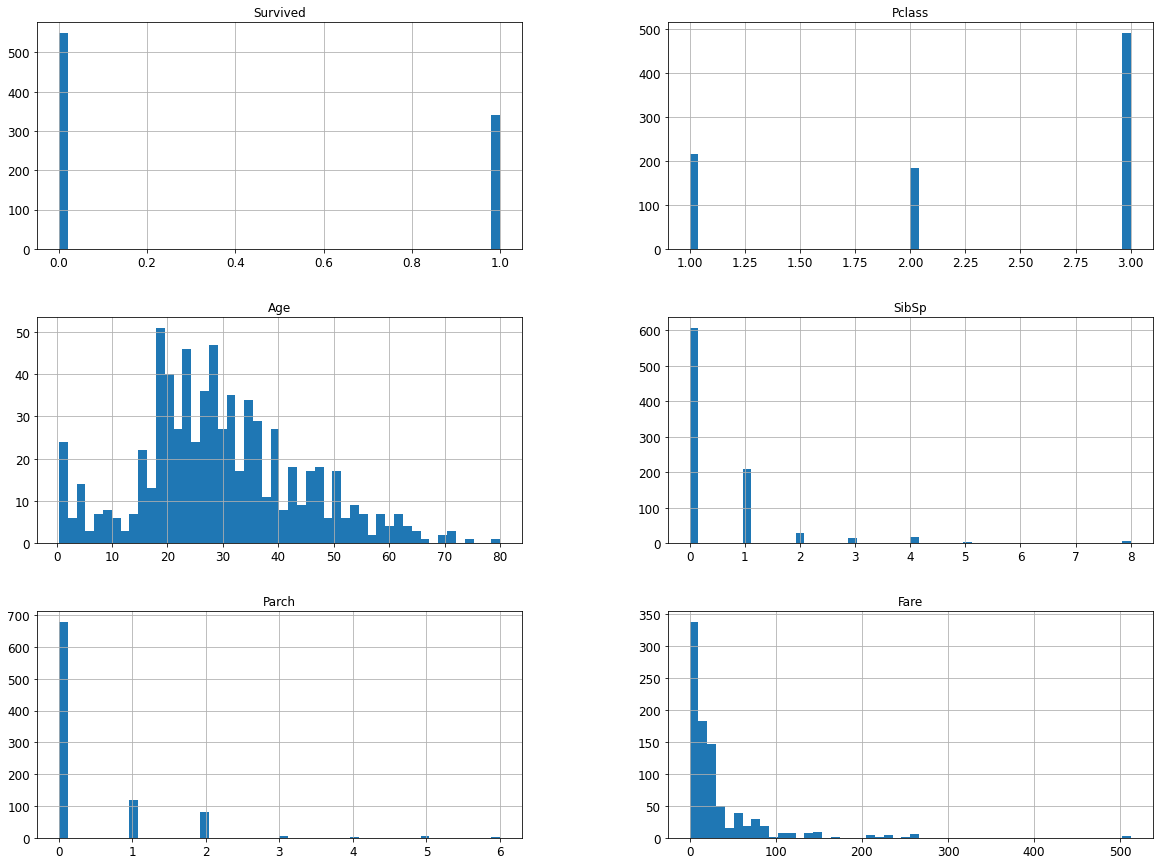

In [9]:
train_data.hist(bins=50, figsize=(20,15))

Got a few tail-heavy distributions namely, `SibSp, Fare, Parch, Age`. Theres seems to be a high number of passengers with 0 cost for their fares.

# 3. Discover and Visualize Data to Give Insights

In [10]:
titanic = train_data.copy()

In [11]:
corr_matrix = titanic.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [12]:
women = titanic.loc[titanic.Sex=='female']["Survived"]
women_rate = sum(women)/len(women)
print("% of women who survived:",women_rate)

% of women who survived: 0.7420382165605095


In [13]:
men = titanic.loc[titanic.Sex=='male']["Survived"]
men_rate = sum(men)/len(men)
print("% of men who survived:",men_rate)

% of men who survived: 0.18890814558058924


It seems that you were more like to survive if you were a women.

In [14]:
age_men_surv = titanic.loc[(titanic["Survived"]==1) & (titanic["Sex"]=="male")]
age_women_surv = titanic.loc[(titanic["Survived"]==1) & (titanic["Sex"]=="female")]

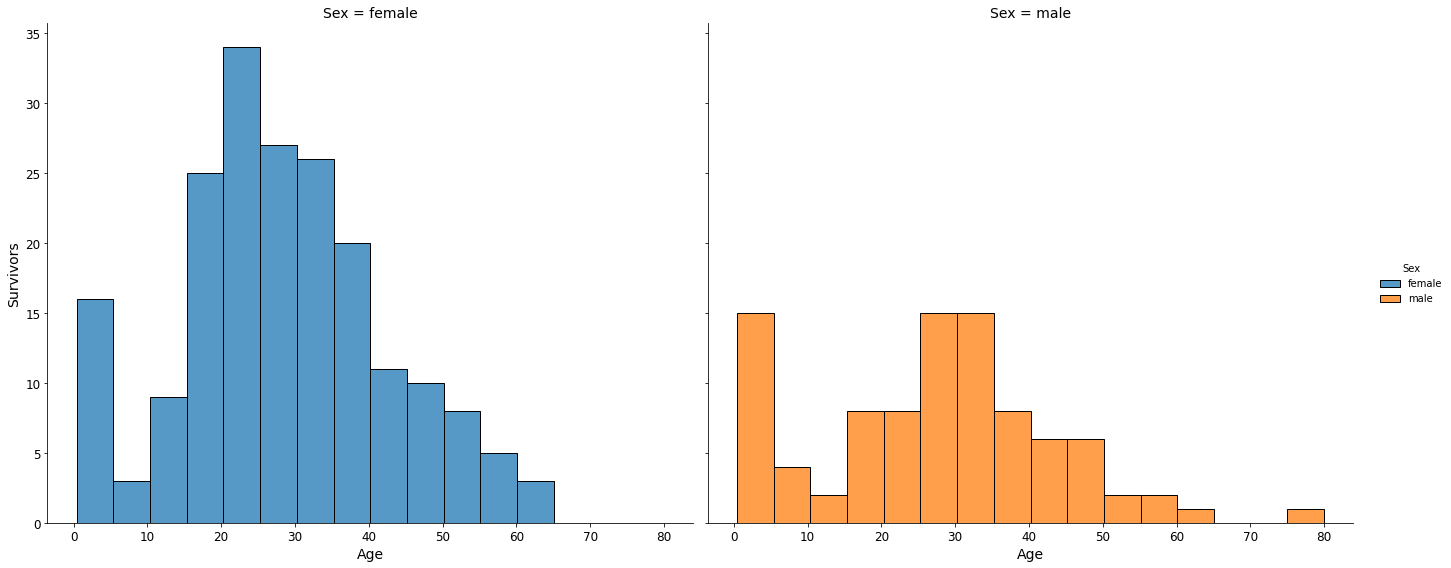

In [15]:
Survivors = titanic.loc[titanic["Survived"]==1]
d = sns.displot(Survivors,x="Age", hue="Sex", col="Sex", height=8, aspect=1.2,)
d.set_axis_labels("Age","Survivors")

Young women, below the age of 40 were more likely to survive.

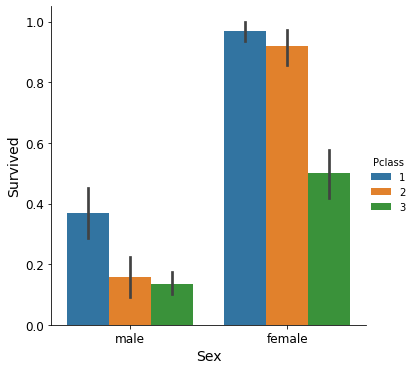

In [16]:
c = sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=titanic, )

<AxesSubplot:xlabel='Embarked', ylabel='count'>

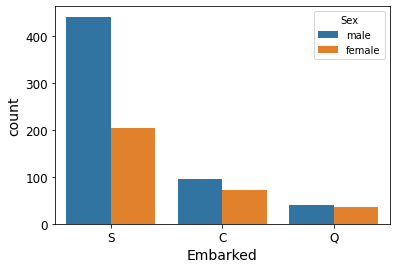

In [17]:
sns.countplot( x='Embarked', hue="Sex", data=titanic)

The higher the passenger's class the more likely they were to survive.

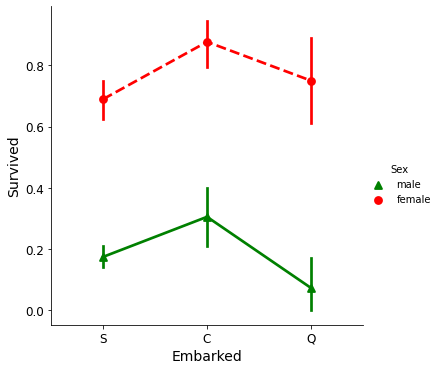

In [18]:
sns.catplot(x="Embarked", y="Survived", hue="Sex",
            palette={"male": "g", "female": "r"},
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=titanic)

Overall in passengers who boarded from Chebourg were more likely to survive. 

However, interestingly:
- Men from Southampton were more likely  to survive than men from Queenstown. 
- However women from Southampton were less likely to survive than women from Queenstown.

# 4. Preparing data for Machine Learning Algorithms

In [19]:
train_data2 = train_data.dropna(axis=0,subset=["Embarked",])
titanic = train_data2.drop(["Survived","Cabin","Name","Ticket"], axis=1)
titanic_labels = train_data2.Survived.copy()

Dropping missing instances where the **Embarked** attribute is missing, as only 2 instances are missing and test_data is not missing any here. 
Dropping **Cabin, Name** and **Ticket** columns as Cabin has too many missing values, Name and Ticket could be parsed for a pattern but will look into another time. 

In [20]:
num_attribs = list(titanic.describe().columns)
cat_attribs = ["Sex","Embarked"]

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [22]:
num_pipeline = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

In [23]:
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

titanic_prepared = full_pipeline.fit_transform(titanic)

# 5. Select Model and Train Model

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()

In [26]:
sgd_scores = cross_val_score(sgd_clf, titanic_prepared, titanic_labels, 
                        cv=5)

In [27]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print("Standard Deviation:", scores.std())

In [28]:
display_scores(sgd_scores)

Scores: [0.78651685 0.65730337 0.76966292 0.82022472 0.76836158]
Mean: 0.7604138894178887
Standard Deviation: 0.054843759105399376


In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [30]:
forest_scores = cross_val_score(forest_clf, titanic_prepared, titanic_labels, 
                        cv=5)

In [31]:
display_scores(forest_scores)

Scores: [0.78651685 0.80337079 0.86516854 0.78089888 0.82485876]
Mean: 0.8121627626483845
Standard Deviation: 0.030604714331495784


In [32]:
from sklearn.svm import SVC

svm_clf = SVC()

In [33]:
svm_scores = cross_val_score(svm_clf, titanic_prepared, titanic_labels, 
                             cv=5, scoring="accuracy")

In [34]:
display_scores(svm_scores)

Scores: [0.8258427  0.8258427  0.81460674 0.81460674 0.85875706]
Mean: 0.8279311877102774
Standard Deviation: 0.01621135314834608


The SVM and Random Forest Classifier produced the best results so I will try tune their hyperparamters.

# 6. Fine-Tuning Models

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
svc_param_grid = [
    {'kernel': ['linear','poly','rbf','sigmoid'], "gamma":['scale','auto']}
]

In [37]:
grid_search = GridSearchCV(svm_clf, svc_param_grid,
                           cv=5, scoring='accuracy',
                           return_train_score=True, verbose=3, refit=True)

In [38]:
grid_search.fit(titanic_prepared,titanic_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .....................gamma=scale, kernel=linear; total time=   0.0s
[CV 2/5] END .....................gamma=scale, kernel=linear; total time=   0.0s
[CV 3/5] END .....................gamma=scale, kernel=linear; total time=   0.0s
[CV 4/5] END .....................gamma=scale, kernel=linear; total time=   0.0s
[CV 5/5] END .....................gamma=scale, kernel=linear; total time=   0.0s
[CV 1/5] END .......................gamma=scale, kernel=poly; total time=   0.0s
[CV 2/5] END .......................gamma=scale, kernel=poly; total time=   0.0s
[CV 3/5] END .......................gamma=scale, kernel=poly; total time=   0.0s
[CV 4/5] END .......................gamma=scale, kernel=poly; total time=   0.0s
[CV 5/5] END .......................gamma=scale, kernel=poly; total time=   0.0s
[CV 1/5] END ........................gamma=scale, kernel=rbf; total time=   0.0s
[CV 2/5] END ........................gamma=scale,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [39]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score,params)

0.7873992255443407 {'gamma': 'scale', 'kernel': 'linear'}
0.824579445185044 {'gamma': 'scale', 'kernel': 'poly'}
0.8279311877102774 {'gamma': 'scale', 'kernel': 'rbf'}
0.68727861359741 {'gamma': 'scale', 'kernel': 'sigmoid'}
0.7873992255443407 {'gamma': 'auto', 'kernel': 'linear'}
0.7829619754967307 {'gamma': 'auto', 'kernel': 'poly'}
0.8279184917158636 {'gamma': 'auto', 'kernel': 'rbf'}
0.699682600139656 {'gamma': 'auto', 'kernel': 'sigmoid'}


In [40]:
grid_search.best_params_

{'gamma': 'scale', 'kernel': 'rbf'}

In [41]:
forest_param_grid = [
    {'n_estimators': [290,300,310], 'max_features':[4,6,8]},
]

In [42]:
grid_search2 = GridSearchCV(forest_clf, forest_param_grid,
                           cv=5, scoring='accuracy',
                           return_train_score=True, verbose=3)

In [43]:
grid_search2.fit(titanic_prepared,titanic_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...............max_features=4, n_estimators=290; total time=   0.5s
[CV 2/5] END ...............max_features=4, n_estimators=290; total time=   0.5s
[CV 3/5] END ...............max_features=4, n_estimators=290; total time=   0.5s
[CV 4/5] END ...............max_features=4, n_estimators=290; total time=   0.5s
[CV 5/5] END ...............max_features=4, n_estimators=290; total time=   0.5s
[CV 1/5] END ...............max_features=4, n_estimators=300; total time=   0.6s
[CV 2/5] END ...............max_features=4, n_estimators=300; total time=   0.6s
[CV 3/5] END ...............max_features=4, n_estimators=300; total time=   0.5s
[CV 4/5] END ...............max_features=4, n_estimators=300; total time=   0.5s
[CV 5/5] END ...............max_features=4, n_estimators=300; total time=   0.5s
[CV 1/5] END ...............max_features=4, n_estimators=310; total time=   0.6s
[CV 2/5] END ...............max_features=4, n_est

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [4, 6, 8],
                          'n_estimators': [290, 300, 310]}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [44]:
grid_search2.best_params_

{'max_features': 6, 'n_estimators': 300}

In [45]:
cvres = grid_search2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score,params)

0.8121627626483845 {'max_features': 4, 'n_estimators': 290}
0.8121627626483845 {'max_features': 4, 'n_estimators': 300}
0.8110328191455596 {'max_features': 4, 'n_estimators': 310}
0.8166825366596839 {'max_features': 6, 'n_estimators': 290}
0.8178061321653018 {'max_features': 6, 'n_estimators': 300}
0.815552593156859 {'max_features': 6, 'n_estimators': 310}
0.8099282676315622 {'max_features': 8, 'n_estimators': 290}
0.812181806640005 {'max_features': 8, 'n_estimators': 300}
0.813305402145623 {'max_features': 8, 'n_estimators': 310}


The SVM classifier performed the better than with an mean accuracy score of **82.8%**; where as the Random Forest Classifier had score of **81.8%**.

In [46]:
best_clf=grid_search.best_estimator_

In [47]:
best_clf

SVC()

# Results

In [48]:
test_dropped = test_data.drop(["Cabin","Ticket","Name"], axis=1)
test_prepared = full_pipeline.transform(test_dropped)

In [49]:
predictions = best_clf.predict(test_prepared)

output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Using the Support Vector Machine (SVM) classifier to be the best so far, acheiving an accuracy of **77.5%** on the test set.